# Vergleich von Medienorganisationen und Parteien

In [39]:
library("httr")
library("jsonlite")
library('dplyr', warn.conflicts = FALSE)
library("ggplot2")

In [40]:
# URLs vorbereiten
base <- "http://mediamonitoring.gesis.org/api/organizations/"
base_pol <- "http://mediamonitoring.gesis.org/api/politicians/"
url_all <- paste(base,"all/", sep="")
url_tweets <- paste(base, "twitter/tweets_by/organizations/", sep="")
url_replies <- paste(base, "twitter/replies_to/organizations/", sep="")
url_tweets_gen <- paste(base_pol,"twitter/general_population/?", sep="")

In [10]:
# Parameter
params = list(
    from_date='2017-07-01',
    to_date='2019-11-30',
    aggregate_by='month'
)

In [12]:
# Wieder alle Organisationen ziehen, diesmal aber nach den 2 Hauptkategorien foltern, nicht nach Subkategorien
orgs <- as.data.frame(fromJSON(content(GET(url_all), "text", encoding="UTF-8"), flatten = TRUE))
media <- orgs[orgs$category == "media"  & !is.null(orgs$tw_ids),]$organization_id
political <- orgs[orgs$category == "political"  & !is.null(orgs$tw_ids),]$organization_id

## Alle Tweets

In [13]:
# Unser bekanntes Schema zum Download

# Einen Data Frame pro Organisationstyp
tweets_media <- data.frame()
tweets_political <- data.frame()

# Tweets ziehen
for (organization_id in media) {
    json_tweets <- fromJSON(content(GET(paste(url_tweets, organization_id, "/?", sep=""),query=params), "text", encoding="UTF-8"), flatten = TRUE)
    if (length(json_tweets$values) != 0) {
        tweets_media <- rbind(tweets_media, as.data.frame(json_tweets))        
    }
}

#Typ-Variable festlegen
tweets_media[['type']] <- "media"

# Tweets ziehen
for (organization_id in political) {
    json_tweets <- fromJSON(content(GET(paste(url_tweets, organization_id, "/?", sep=""),query=params), "text", encoding="UTF-8"), flatten = TRUE)
    if (length(json_tweets$values) != 0) {
        tweets_political <- rbind(tweets_political, as.data.frame(json_tweets))        
    }
}
#Typ-Variable festlegen
tweets_political[['type']] <- "political"


In [14]:
# Zusammensetzen
all <- rbind(tweets_media, tweets_political)

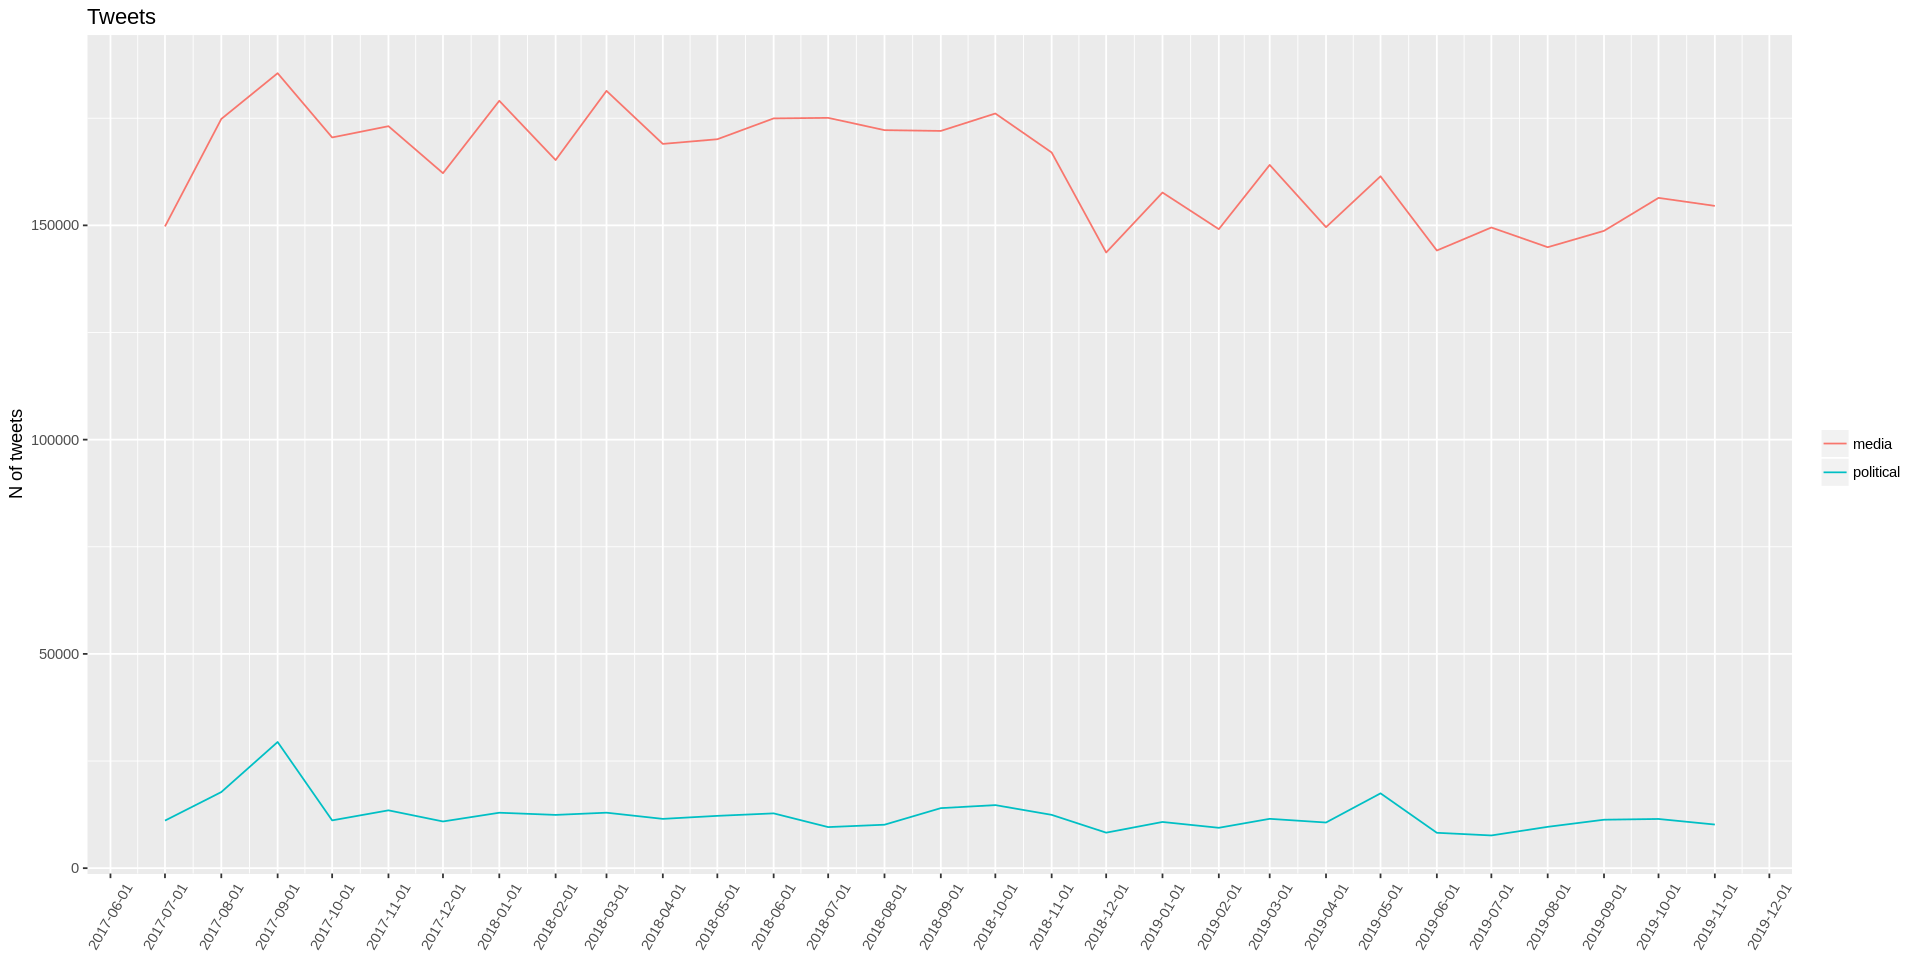

In [15]:

options(repr.plot.width=16, repr.plot.height=8)

# plotting tweets 
ggplot(data=all, aes(x=as.Date(labels), y=values)) + stat_summary(fun.y = sum, geom="line", aes(colour = type)) +

    #geom_point(aes(colour = factor(party))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Tweets", y = "N of tweets") +
    scale_x_date(date_breaks = "1 month") 

## Tweets mit "Migration" als Thema

In [17]:
migration <- paste(readLines("Migration.txt"))

In [18]:
url_tweets_topics <- paste(base, "twitter/tweets_by/organizations", sep="")
url_tweets_pol <- paste(base_pol,"twitter/tweets_by/politicians", sep="")

params = list(
    from_date='2017-01-01',
    to_date='2019-11-30',
    aggregate_by='month',
    text_contains=migration
)

In [19]:
# Noch einmal genauso wie oben

# Einen Data Frame pro Organisationstyp
tweets_media <- data.frame()
tweets_political <- data.frame()

# Tweets ziehen
for (organization_id in media) {
    json_tweets <- fromJSON(content(GET(paste(url_tweets, organization_id, "/?", sep=""),query=params), "text", encoding="UTF-8"), flatten = TRUE)
    if (length(json_tweets$values) != 0) {
        tweets_media <- rbind(tweets_media, as.data.frame(json_tweets))        
    }
}

#Typ-Variable festlegen
tweets_media[['type']] <- "media"

# Tweets ziehen
for (organization_id in political) {
    json_tweets <- fromJSON(content(GET(paste(url_tweets, organization_id, "/?", sep=""),query=params), "text", encoding="UTF-8"), flatten = TRUE)
    if (length(json_tweets$values) != 0) {
        tweets_political <- rbind(tweets_political, as.data.frame(json_tweets))        
    }
}
#Typ-Variable festlegen
tweets_political[['type']] <- "political"


In [20]:
# Zusammensetzen
all <- rbind(tweets_media, tweets_political)

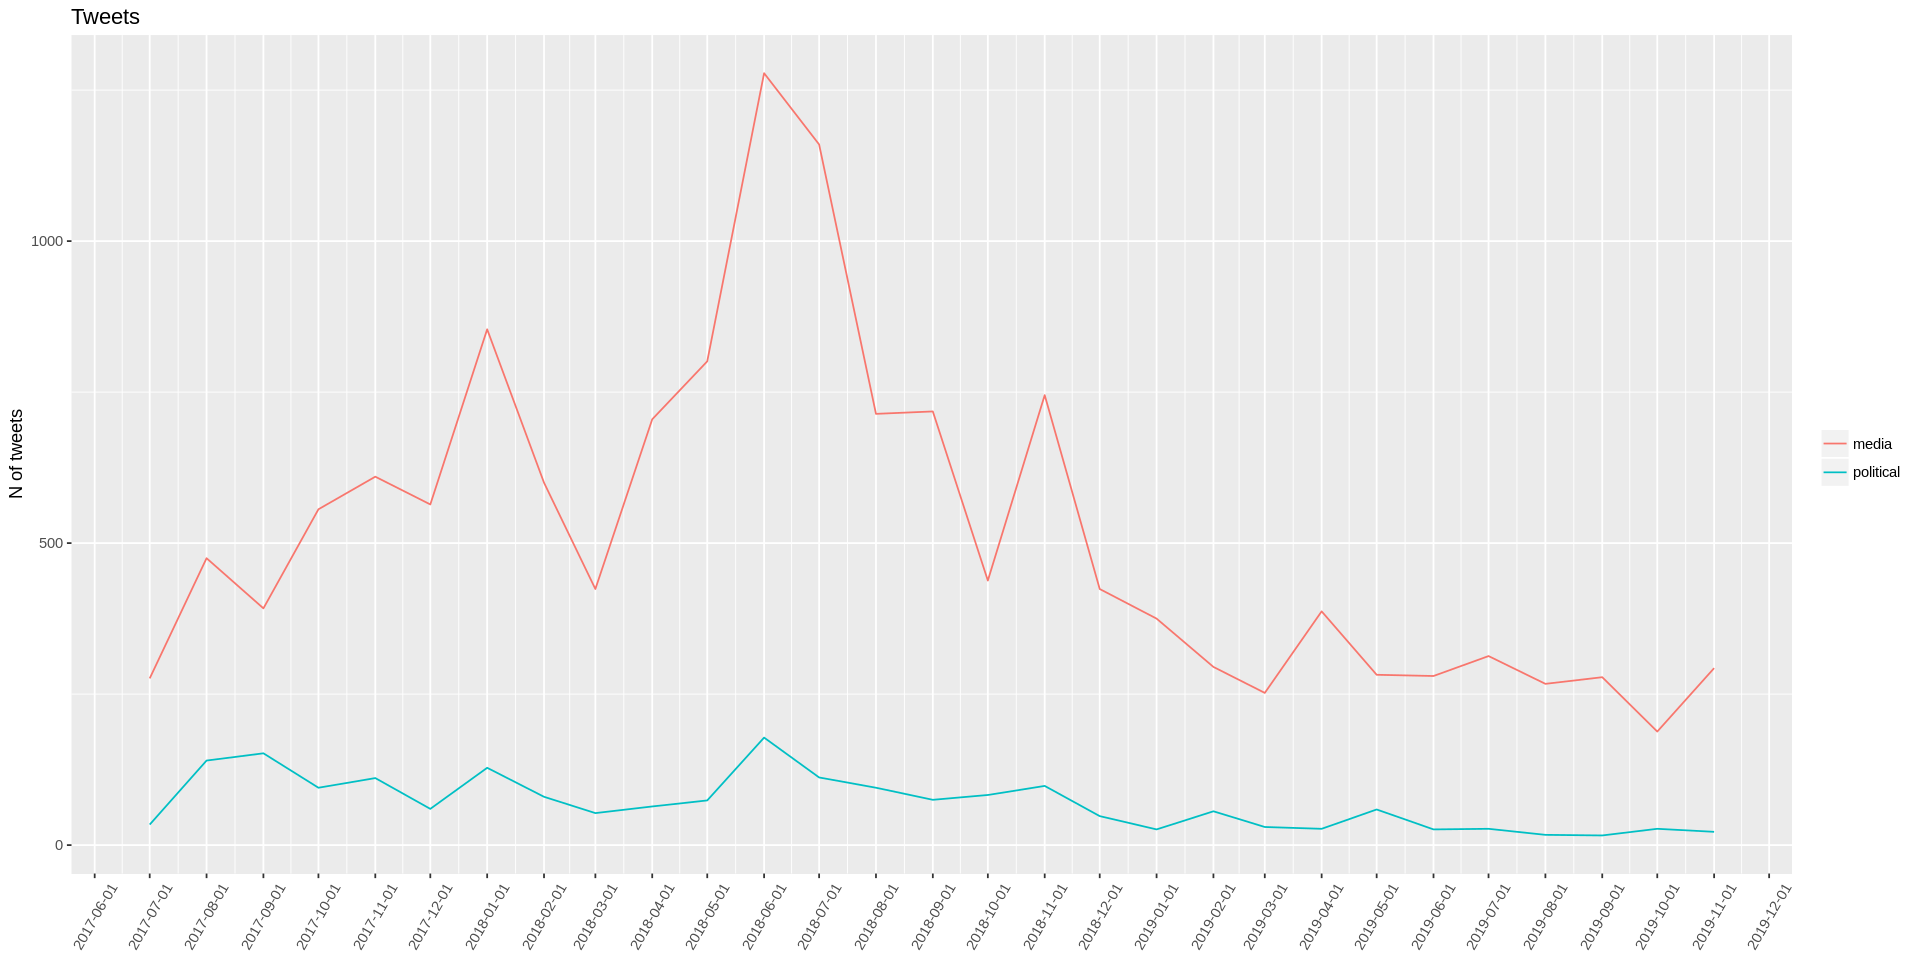

In [21]:
# plotting tweets 
ggplot(data=all, aes(x=as.Date(labels), y=values)) + stat_summary(fun.y = sum, geom="line", aes(colour = type)) +

    #geom_point(aes(colour = factor(party))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Tweets", y = "N of tweets") +
    scale_x_date(date_breaks = "1 month") 

# Noch eine weitere API: Abgeordnetenwatch.de

https://www.abgeordnetenwatch.de/api

Wir können uns Daten zu Abstimmungen ziehen, die Migrations-Keywords in Titel, Zusammenfassung oder Kategorie haben



In [43]:
#Abstimmungen im Bundestag  und zwei Landtagen

bundestag <- as.data.frame(fromJSON(content(GET(paste("https://www.abgeordnetenwatch.de/api/parliament/bundestag/polls.json")), "text", encoding="UTF-8"), flatten = TRUE)$polls)
bavaria <- as.data.frame(fromJSON(content(GET(paste("https://www.abgeordnetenwatch.de/api/parliament/bayern%202013-2018/polls.json")), "text", encoding="UTF-8"), flatten = TRUE)$polls)
badenw <- as.data.frame(fromJSON(content(GET(paste("https://www.abgeordnetenwatch.de/api/parliament/baden-w%C3%BCrttemberg/polls.json")), "text", encoding="UTF-8"), flatten = TRUE)$polls)

In [45]:
migration_keywords <- as.list(strsplit(migration, '\\|')[[1]])


retrieve_dates <- function(votes, migration_keywords) {
    dates = list()
    for (word in migration_keywords) {
        migration_df <- votes[ which(grepl(word, votes$meta.topics, fixed=TRUE) | grepl(word, votes$title, fixed=TRUE) | grepl(word, votes$summary, fixed=TRUE)), ]
        for (date in migration_df$date)
            dates[[ (length(dates) + 1) ]] <-date
        }
    return(dates)
    }

# Abruf der Daten der Abstimmungen mit Thema Migration
dates_bundestag <- retrieve_dates(bundestag, migration_keywords)
dates_bavaria <- retrieve_dates(bavaria, migration_keywords)
dates_badenw <- retrieve_dates(badenw, migration_keywords)


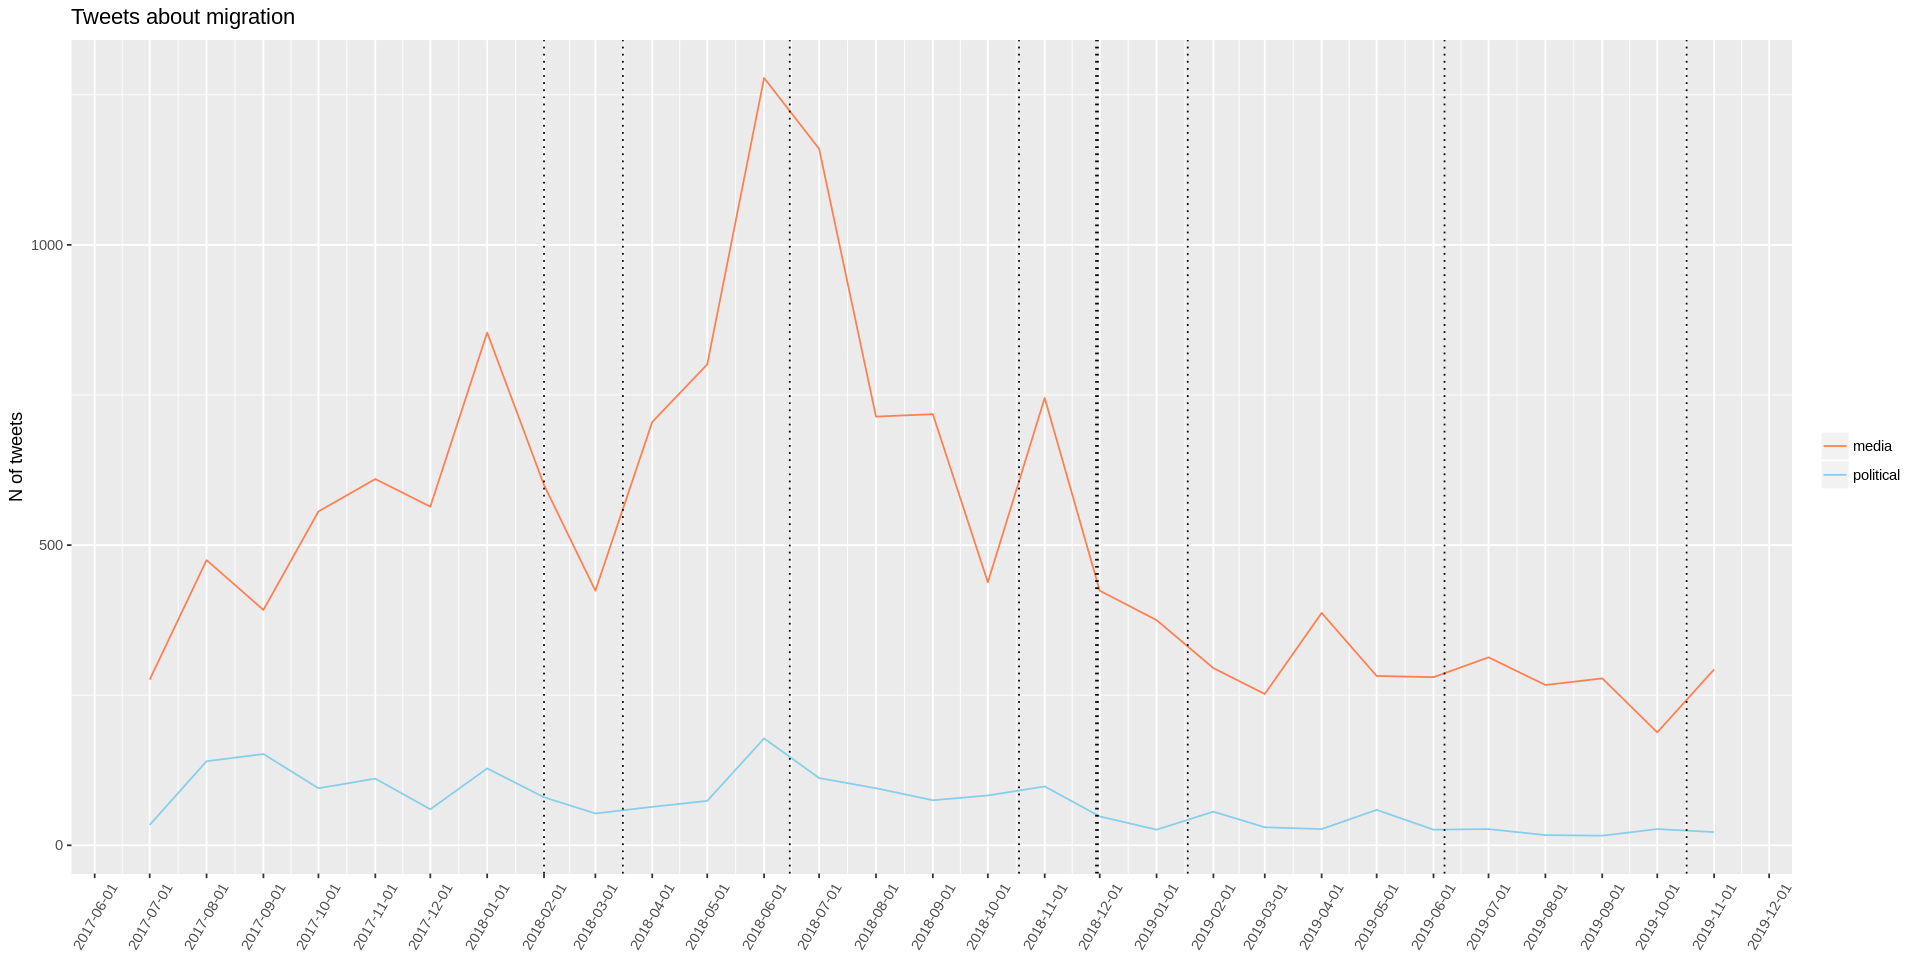

In [59]:
# Tweets zu Migration

lp_0 <- ggplot(data=all, aes(x=as.Date(labels), y=values)) + stat_summary(fun.y = sum, geom="line", aes(colour = type)) +

   
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
    axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Tweets about migration", y = "N of tweets") +
    scale_color_manual(values=c("coral", "skyblue")) +
    scale_x_date(date_breaks = "1 month") 

for (date in unique(dates_bundestag))
    lp_0 <- lp_0 + geom_vline(xintercept = as.Date(date), linetype="dotted",color = "black") 
    #lp_0 <- lp_0 + geom_vline(aes(xintercept = as.Date(date), linetype = "dotted"), colour= 'red') 
#for (date in unique(dates_bavaria))
#    lp_0 <- lp_0 + geom_vline(xintercept = as.Date(date), linetype="dotted", color = "blue") 
#for (date in unique(dates_badenw))
#    lp_0 <- lp_0 + geom_vline(xintercept = as.Date(date), linetype="dotted", color = "green") 
lp_0

Die gleiche Abfrage inklusive der Politiker-Tweets

In [56]:
tweets_pol = as.data.frame(fromJSON(content(GET(url_tweets_pol, query=params), "text", encoding="UTF-8"), flatten = TRUE))
tweets_gen = as.data.frame(fromJSON(content(GET(url_tweets_gen, query=params), "text", encoding="UTF-8"), flatten = TRUE))
tweets_pol[['type']] <- "Politician"
all_with_pol <- rbind(all, tweets_pol)

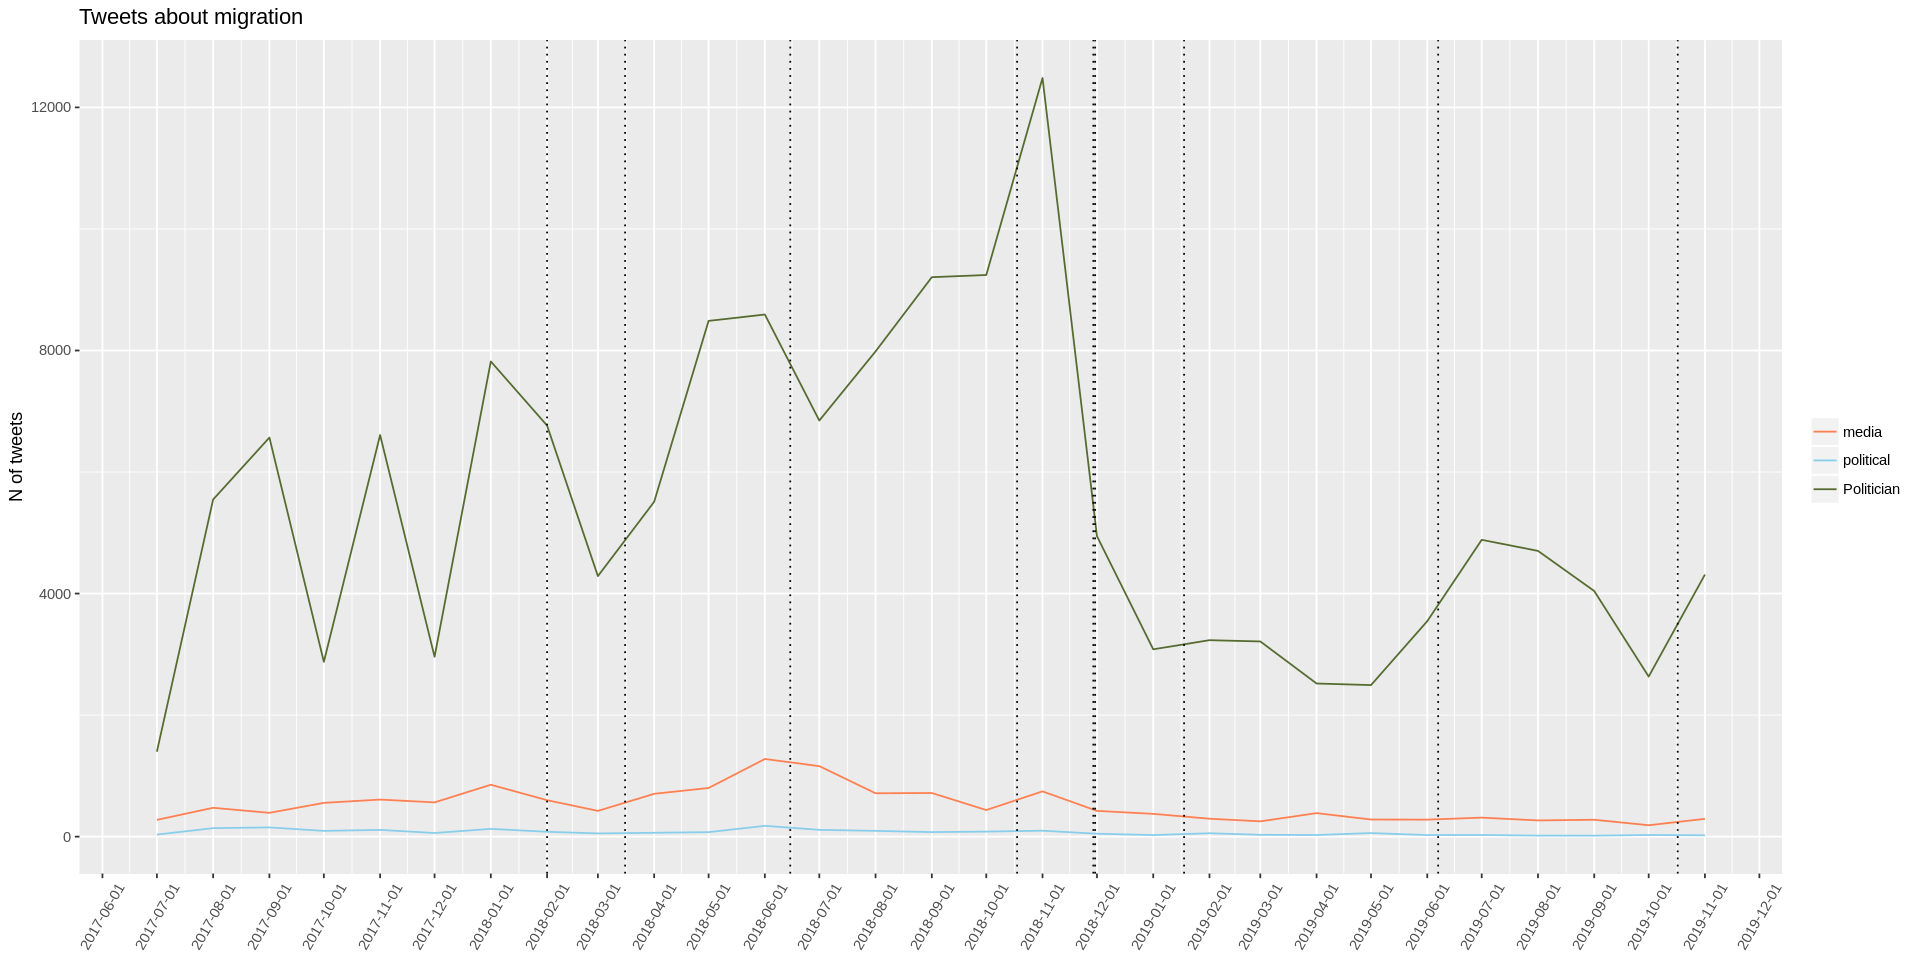

In [60]:
# plotting tweets about migration
lp <- ggplot(data=all_with_pol, aes(x=as.Date(labels), y=values)) + stat_summary(fun.y = sum, geom="line", aes(colour = type)) +

    #geom_point(aes(colour = factor(party))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Tweets about migration", y = "N of tweets") +
    scale_color_manual(values=c("coral", "skyblue", "darkolivegreen")) +
    scale_x_date(date_breaks = "1 month") 

for (date in unique(dates_bundestag))
    lp <- lp + geom_vline(xintercept = as.Date(date), linetype="dotted", color = "black") 
lp